In [1]:
import warnings
from tokenize import endpats

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statannotations.Annotator import Annotator
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('source/FReDA3.csv')
df2 = pd.read_csv('source/FReDA4.csv')

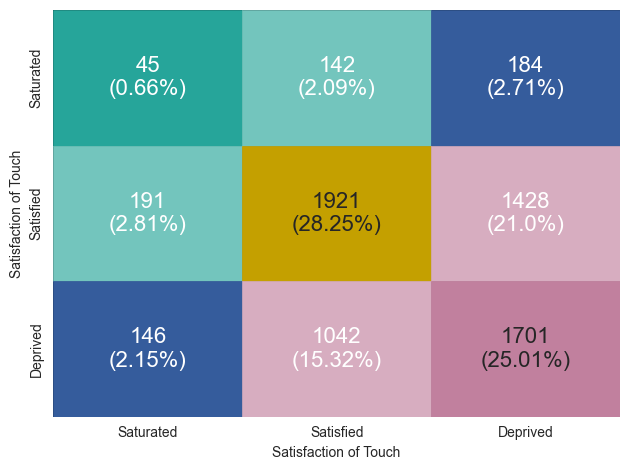

In [3]:
# ensure ordered categorical
df2['Perception'] = pd.Categorical(
    df2['Perception'],
    # categories=['Deprived', 'Satisfied', 'Saturated'],
    categories=['Saturated', 'Satisfied', 'Deprived'],
    ordered=True
)

# reshape: one row per dyad, one column per role
wide = (
    df2
    .pivot(index='CoupleId', columns='Role', values='Perception')
    .rename(columns={
        'Anchor': 'Anchor Perception',
        'Partner': 'Partner Perception'
    })
)

# absolute counts
crosstab = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception']
)

# percentages of total
crosstab_pct = pd.crosstab(
    wide['Anchor Perception'],
    wide['Partner Perception'],
    normalize='all'
) * 100

annot = crosstab.astype(str) + "\n(" + crosstab_pct.round(2).astype(str) + "%)"

cell_colors = np.array([
    # ['#c1809e', '#d7adc0', '#355C9C'],
    # ['#d7adc0', '#C4A000', '#73c5bd'],
    # ['#355C9C', '#73c5bd', '#26a59a']
    ['#26a59a', '#73c5bd', '#355C9C'],
    ['#73c5bd', '#C4A000', '#d7adc0'],
    ['#355C9C', '#d7adc0', '#c1809e']
])

colours2 = ['#C4A000',
            '#c1809e',
            '#d7adc0',
            '#26a59a',
            '#73c5bd',
            '#355C9C']

fig, ax = plt.subplots()
sns.heatmap(
    data=crosstab,
    # annot=True,
    annot=annot,
    # fmt='d',
    fmt='',
    cbar=False,
    annot_kws={"fontsize": 16},
    linewidths=0.5,
    linecolor='black',
)
# Set the facecolor of each cell
for i in range(crosstab.shape[0]):
    for j in range(crosstab.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=cell_colors[i, j], edgecolor='black', lw=0.5))

plt.xlabel("Satisfaction of Touch")
plt.ylabel("Satisfaction of Touch")
plt.tight_layout()
plt.savefig('output/img/poster/divergence3.png', dpi=600, transparent=False, bbox_inches='tight')

CORRELATION MAPS

In [4]:
df2.loc[(df2['Kids'] == 0), "Kids binary"] = 0
df2.loc[(df2['Kids'] >= 1), "Kids binary"] = 1

couples_satisfied = df[df["Group3"] == "Couple Satisfaction"].copy()
couples_deprived = df[df["Group3"] == "Couple Deprivation"].copy()
couples_saturated = df[df["Group3"] == "Couple Saturation"].copy()
couples_mixed = df[df["Group3"] == "Couple Mixed"].copy()

In [5]:
touch_factors = [
    'Frequency',
    'Desire',
]

individual_factors = [
    'Sex',
    'Age',
    'Work Status',
    'Urbanization',
    'Education',
    'Region'

]

personality_factors = [
    'Neuroticism',
    'Extraversion',
    'Conscientiousness',
    'Openness',
    'Agreeableness',
]

wellbeing_factors = [
    'Depressiveness',
    'Loneliness',
    'Self-esteem',
    'Life Satisfaction',
    'Health',
]

relationship_factors = [
    'Relationship Length',
    'Age difference',
    'Married',
    'Cohabitation',
    'Kids',

    'Relationship Satisfaction',
    'Communication Quality',
    'Conflict Management',
]

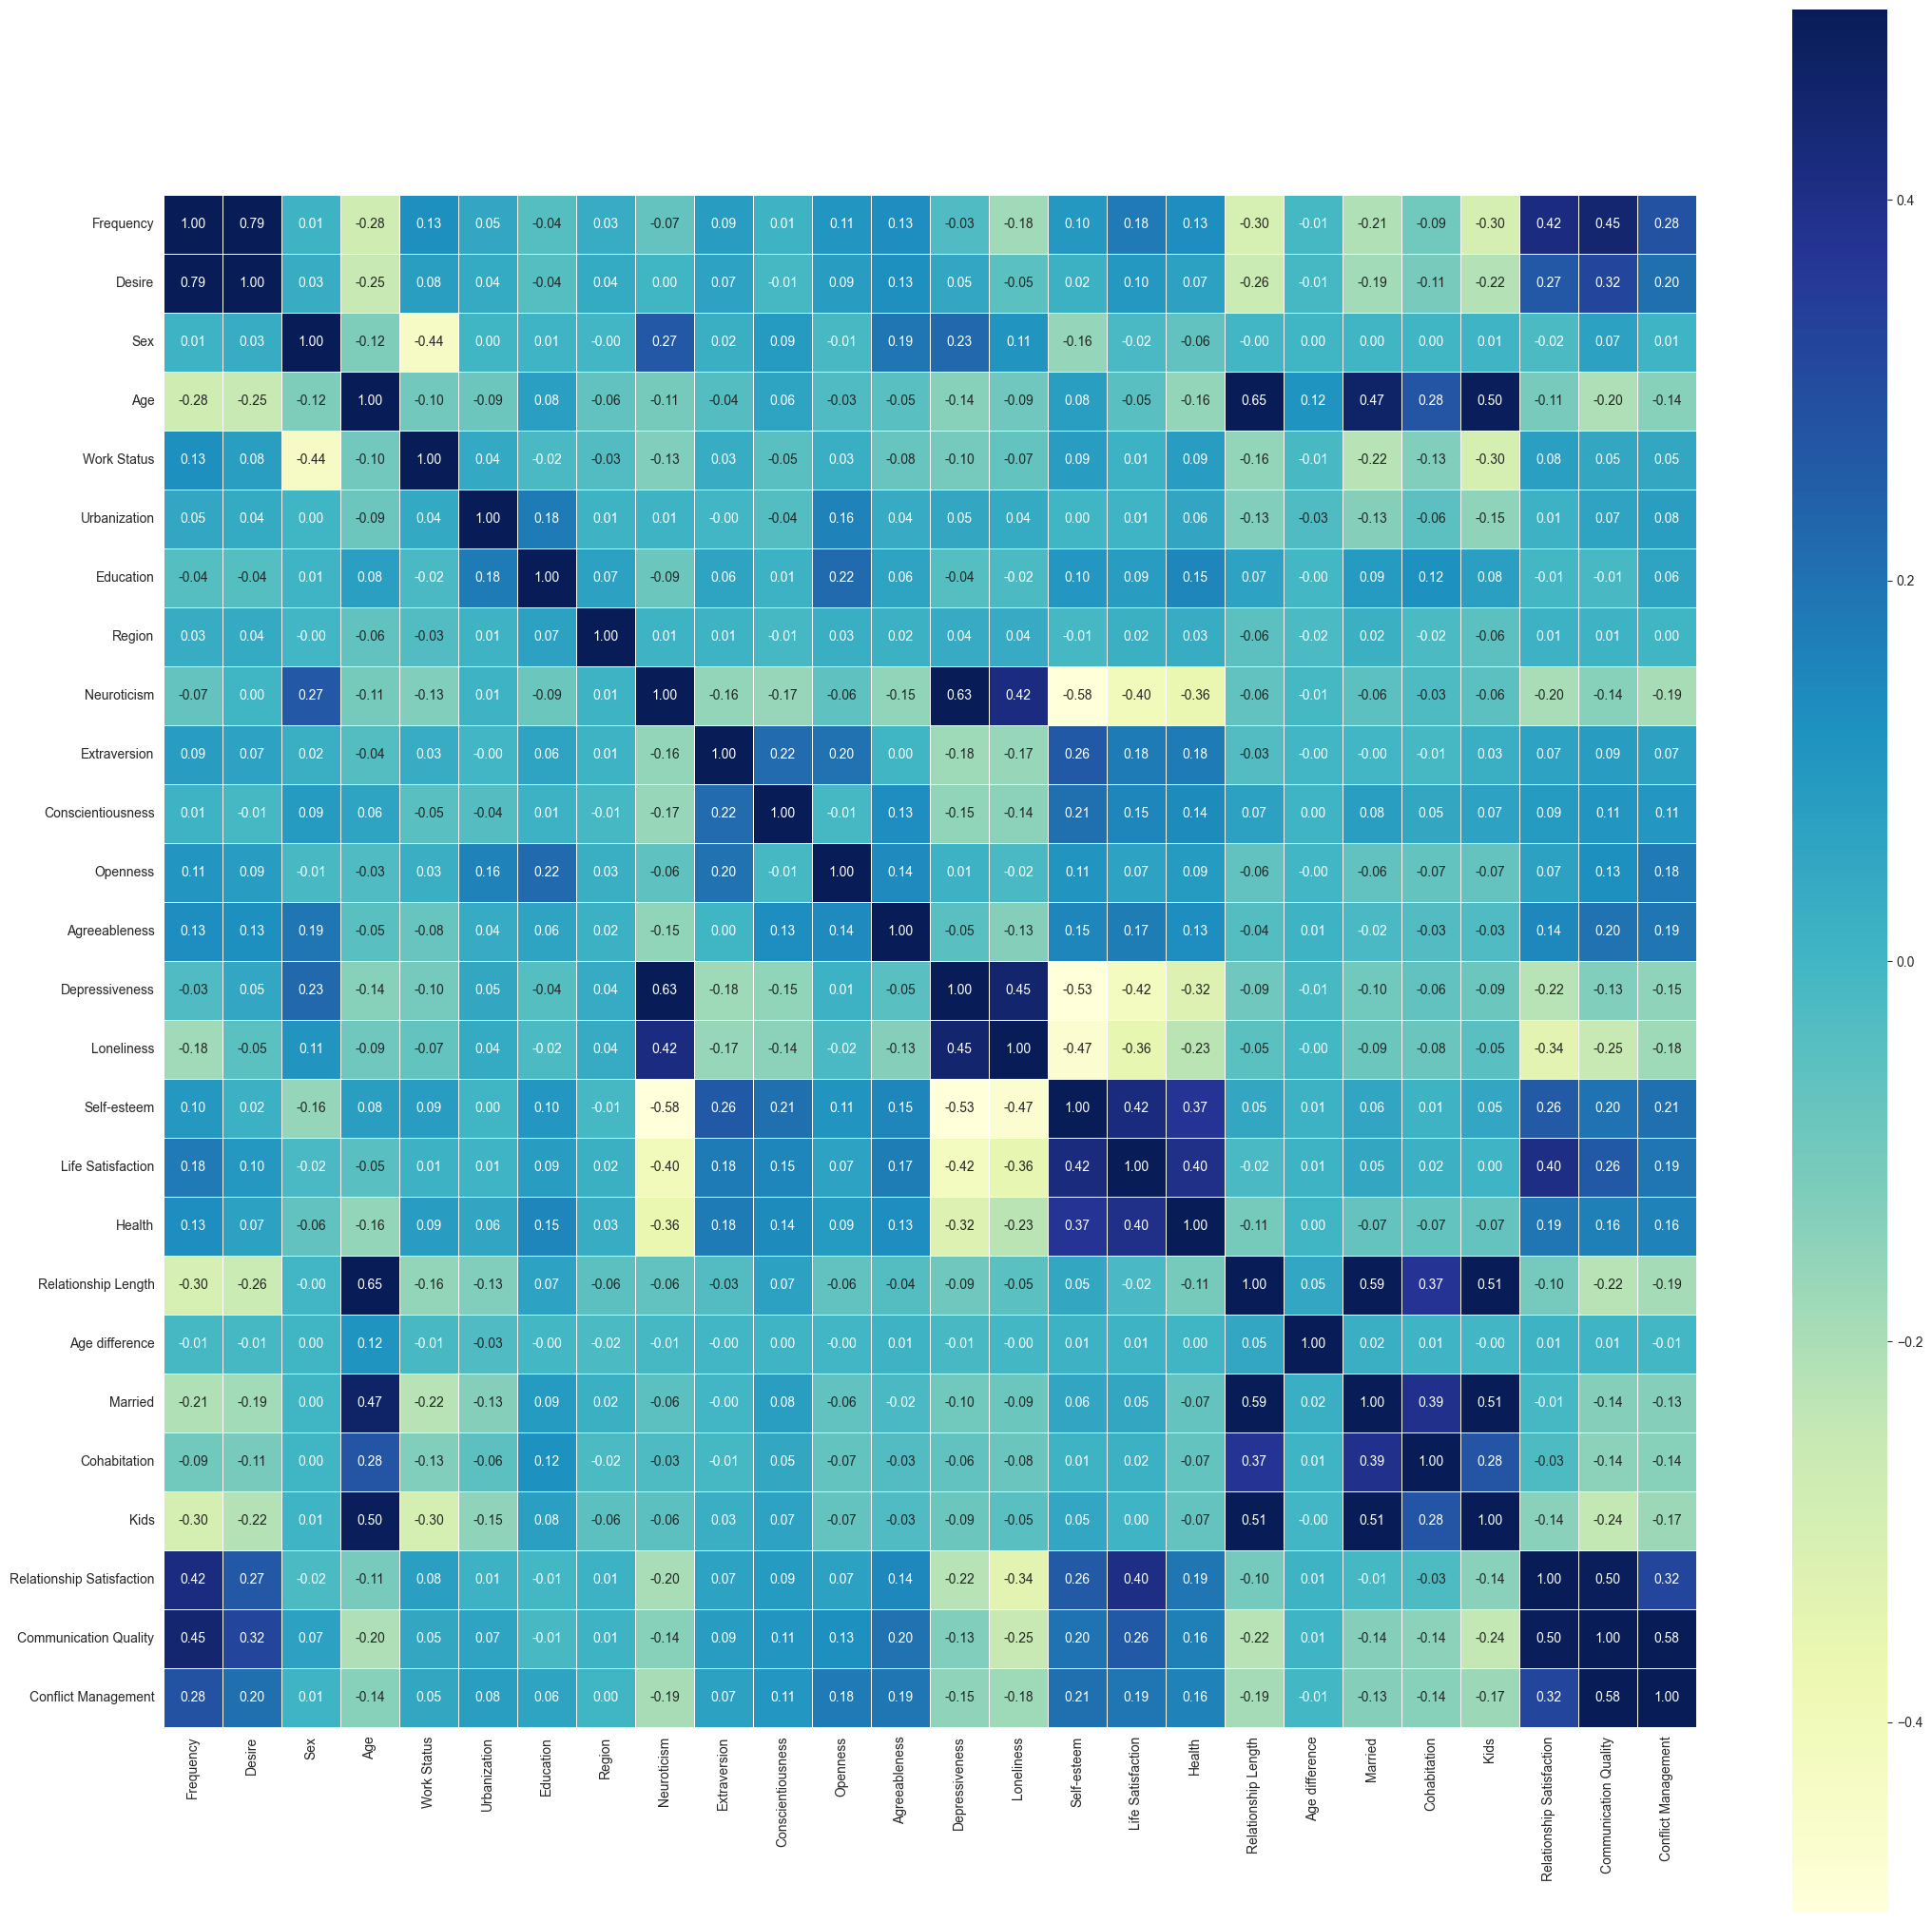

In [6]:
correlation = df2[
    touch_factors +
    individual_factors +
    personality_factors +
    wellbeing_factors +
    relationship_factors
    ].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1  # in inches, per cell

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation, cmap='YlGnBu',
            fmt='.2f',
            linewidths=0.5,
            vmax=0.5,
            vmin=-0.5,
            annot_kws={"size": 10},
            annot=True,
            square=True
            )

plt.grid(False)
# plt.savefig('output/img/poster/correlation.png', dpi=600, transparent=False, bbox_inches='tight')

In [7]:
cols = touch_factors + individual_factors + personality_factors + wellbeing_factors + relationship_factors

# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
pval_matrix = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

# Fill in the matrices
for i in range(len(cols)):
    for j in range(i, len(cols)):
        col1 = cols[i]
        col2 = cols[j]
        r, p = spearmanr(df2[col1], df2[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

In [8]:
from scipy.stats import chi2_contingency

# Difference by sex in Frequency?
# hypothesis test of independence of the observed frequencies
contingency = pd.crosstab(df2['Couple Frequency'], df2['Couple Desire'])
res = chi2_contingency(contingency)
print("--- Couple Touch ---")
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")
# Chi Square contingency test suggest that there is a strong association between Frequency and Desire, as null hypothesis is rejected.

touch_factors = [
    'Anchor Frequency',
    'Anchor Desire',
    'Anchor Kiss Frequency',
    'Anchor Kiss Desire',
    "Anchor Hold Frequency",
    "Anchor Hold Desire",
    'Anchor Hug Frequency',
    'Anchor Hug Desire',
    'Partner Frequency',
    'Partner Desire',
    'Partner Kiss Frequency',
    'Partner Kiss Desire',
    "Partner Hold Frequency",
    "Partner Hold Desire",
    'Partner Hug Frequency',
    'Partner Hug Desire',
]

--- Couple Touch ---
Dof:1764, Chi-square: 76196.43865246663, p-value: 0.0


In [9]:
def alpha_palette(hex_color, n=7, min_alpha=0.2, max_alpha=1.0, perceptual=True):
    rgb = mcolors.to_rgb(hex_color)

    if perceptual:
        alphas = np.geomspace(min_alpha, max_alpha, n)
    else:
        alphas = np.linspace(min_alpha, max_alpha, n)

    colors_map = [(rgb[0], rgb[1], rgb[2], a) for a in alphas]
    return ListedColormap(colors_map)


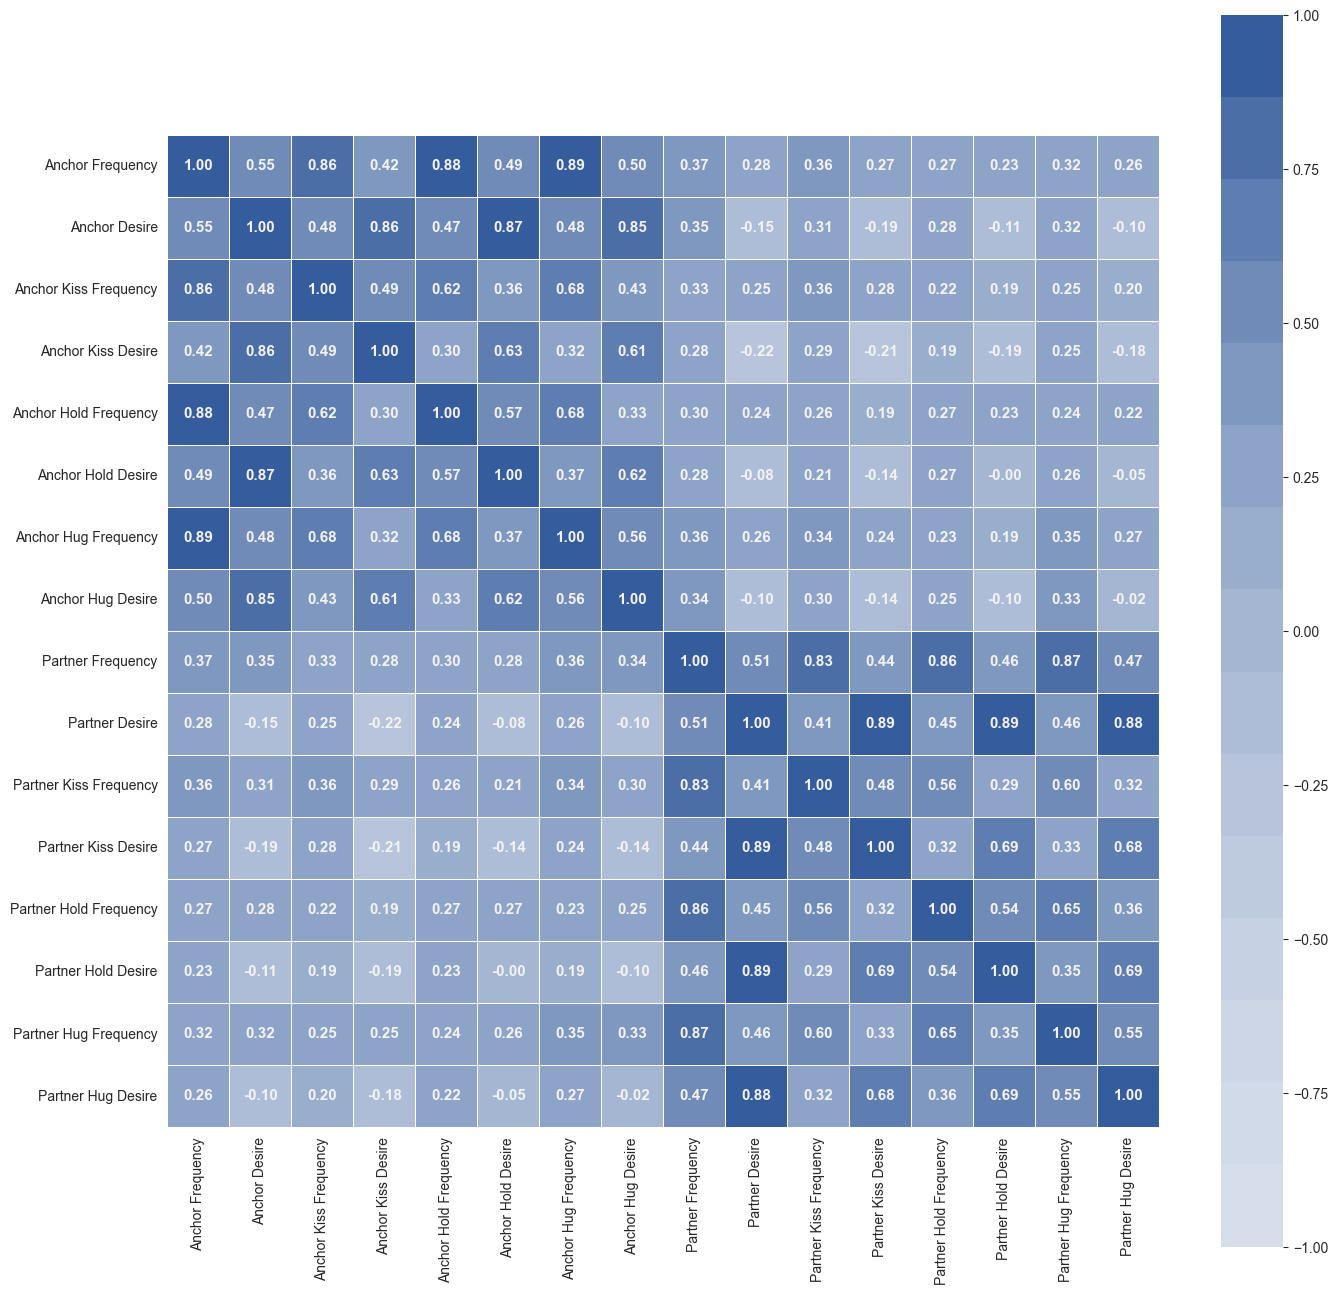

In [10]:
dfs = [couples_satisfied,
       couples_deprived,
       couples_saturated,
       couples_mixed]

cols = ['#C4A000',
        '#c1809e',
        '#26a59a',
        '#355C9C']

fonts = ["#222222",
         "#222222",
         "#333333",
         "#F2F2F2"]

f = 3

target_df = dfs[f]
target_col = cols[f]
target_font = fonts[f]

cmap = alpha_palette(target_col, n=15)

correlation = target_df[
    touch_factors
].corr(method='spearman')

num_vars = len(correlation.columns)
square_size = 1

fig_width = num_vars * square_size
fig_height = num_vars * square_size

plt.figure(figsize=(fig_width, fig_height))

sns.heatmap(correlation,
            cmap=cmap,
            fmt='.2f',
            linewidths=0.5,
            vmax=1,
            vmin=-1,
            annot_kws={"size": 11,
                       "fontweight": "bold",
                       "color": target_font
                       },
            annot=True,
            square=True
            )
plt.grid(False)
# plt.savefig('output/img/correlation/correlation_mix.png', dpi=600, transparent=False, bbox_inches='tight')

column = touch_factors
# Initialize matrices for correlation and p-values
corr_matrix = pd.DataFrame(np.zeros((len(column), len(column))), columns=column, index=column)
pval_matrix = pd.DataFrame(np.ones((len(column), len(column))), columns=column, index=column)

# Fill in the matrices
for i in range(len(column)):
    for j in range(i, len(column)):
        col1 = column[i]
        col2 = column[j]
        r, p = spearmanr(target_df[col1], target_df[col2], nan_policy='omit')
        corr_matrix.loc[col1, col2] = r
        corr_matrix.loc[col2, col1] = r
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p


In [11]:
couples_satisfied = df2[df2["Group3"] == "Couple Satisfaction"].copy()
couples_deprived = df2[df2["Group3"] == "Couple Deprivation"].copy()
couples_saturated = df2[df2["Group3"] == "Couple Saturation"].copy()
couples_mixed = df2[df2["Group3"] == "Couple Mixed"].copy()

In [12]:
count_base = couples_satisfied['Work Status'].value_counts(dropna=False)
count_d = couples_deprived['Work Status'].value_counts(dropna=False)
count_s = couples_saturated['Work Status'].value_counts(dropna=False)
count_m = couples_mixed['Work Status'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
res = chi2_contingency(contingency)
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

             Satisfied  Deprived  Saturated  Mixed
Work Status                                       
2.0               2902      5460        564    460
1.0                595      1783        105    122
0.0                306      1000         77     73
NaN                 39        99         10      5
Dof:9, Chi-square: 143.78243557225844, p-value: 1.70656247081848e-26


In [13]:
count_base = couples_satisfied['Urbanization'].value_counts(dropna=False)
count_d = couples_deprived['Urbanization'].value_counts(dropna=False)
count_s = couples_saturated['Urbanization'].value_counts(dropna=False)
count_m = couples_mixed['Urbanization'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})

print(contingency)
# res = chi2_contingency(contingency)
# print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

              Satisfied  Deprived  Saturated  Mixed
Urbanization                                       
0.0                 706      1643        140    105
1.0                1535      3451        278    242
2.0                1496      3027        318    288
NaN                 105       221         20     25


In [14]:
count_base = couples_satisfied['Education'].value_counts(dropna=False)
count_d = couples_deprived['Education'].value_counts(dropna=False)
count_s = couples_saturated['Education'].value_counts(dropna=False)
count_m = couples_mixed['Education'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})
print(contingency)
# res = chi2_contingency(contingency)
# print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

           Satisfied  Deprived  Saturated  Mixed
Education                                       
0.0               97        82         20      6
1.0               14        54          8      3
2.0               35        83         16     13
3.0              821      1886        219    166
4.0              518      1151         91    103
6.0             1207      2616        194    178
7.0              697      1569        114    118
8.0              139       343         12     24
NaN              314       558         82     49


In [15]:
count_base = couples_satisfied['Kids binary'].value_counts(dropna=False)
count_d = couples_deprived['Kids binary'].value_counts(dropna=False)
count_s = couples_saturated['Kids binary'].value_counts(dropna=False)
count_m = couples_mixed['Kids binary'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})
print(contingency)
# res = chi2_contingency(contingency)
# print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

             Satisfied  Deprived  Saturated  Mixed
Kids binary                                       
0.0               2124      2760      434.0    282
1.0               1716      5576      322.0    376
NaN                  2         6        NaN      2


In [16]:
count_base = couples_satisfied['Region'].value_counts(dropna=False)
count_d = couples_deprived['Region'].value_counts(dropna=False)
count_s = couples_saturated['Region'].value_counts(dropna=False)
count_m = couples_mixed['Region'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})
print(contingency)
# res = chi2_contingency(contingency)
# print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

        Satisfied  Deprived  Saturated  Mixed
Region                                       
1.0          3210      6858        621    533
0.0           533      1273        115    102
NaN            99       211         20     25


In [17]:
count_base = couples_satisfied['Married'].value_counts(dropna=False)
count_d = couples_deprived['Married'].value_counts(dropna=False)
count_s = couples_saturated['Married'].value_counts(dropna=False)
count_m = couples_mixed['Married'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})
print(contingency)
# res = chi2_contingency(contingency)
# print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

         Satisfied  Deprived  Saturated  Mixed
Married                                       
0.0         1626.0    2600.0      352.0    246
1.0         2216.0    5742.0      404.0    412
NaN            NaN       NaN        NaN      2


In [18]:
count_base = couples_satisfied['Sex'].value_counts(dropna=False)
count_d = couples_deprived['Sex'].value_counts(dropna=False)
count_s = couples_saturated['Sex'].value_counts(dropna=False)
count_m = couples_mixed['Sex'].value_counts(dropna=False)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    'Deprived': count_d,
    'Saturated': count_s,
    'Mixed': count_m,
})
# print(contingency)
res = chi2_contingency(contingency)
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

Dof:6, Chi-square: 8.646884612759026, p-value: 0.19443244492334577


In [19]:
count_base = couples_satisfied['Relationship Sex'].value_counts(dropna=True)
count_d = couples_deprived['Relationship Sex'].value_counts(dropna=True)
count_s = couples_saturated['Relationship Sex'].value_counts(dropna=True)
count_m = couples_mixed['Relationship Sex'].value_counts(dropna=True)

contingency = pd.DataFrame({
    'Satisfied': count_base,
    # 'Deprived': count_d,
    # 'Saturated': count_s,
    'Mixed': count_m,
})
# print(contingency)
res = chi2_contingency(contingency)
print(f"Dof:{res.dof}, Chi-square: {res.statistic}, p-value: {res.pvalue}")

Dof:1, Chi-square: 0.0003155964638853853, p-value: 0.9858262984884236


In [35]:
count_base = couples_satisfied['Age']
count_d = couples_deprived['Age']
count_s = couples_saturated['Age']
count_m = couples_mixed['Age']

rvs1 = count_base
rvs2 = count_m

t, p = stats.ttest_ind(rvs1, rvs2, equal_var=False)
m1, sd1, n1 = rvs1.mean(), rvs1.std(ddof=1), len(rvs1)
m2, sd2, n2 = rvs2.mean(), rvs2.std(ddof=1), len(rvs2)
s1, s2 = sd1 ** 2, sd2 ** 2

df = (s1 / n1 + s2 / n2) ** 2 / (
        (s1 / n1) ** 2 / (n1 - 1) + (s2 / n2) ** 2 / (n2 - 1)
)
sd_pooled = np.sqrt((s1 + s2) / 2)
d = (m1 - m2) / sd_pooled


report = (
    f"An independent-samples Welch’s t-test showed that "
    f"Group A (M = {m1:.2f}, SD = {sd1:.2f}) scored higher than "
    f"Group B (M = {m2:.2f}, SD = {sd2:.2f}), "
    f"t({df:.2f}) = {t:.2f}, p {p}, d = {d:.2f}."
)
print(report)

An independent-samples Welch’s t-test showed that Group A (M = 35.87, SD = 9.07) scored higher than Group B (M = 36.38, SD = 8.49), t(936.43) = -1.44, p 0.15142143056957713, d = -0.06.
